## 動作前チェック
* カーネル選択
* 軌道パス
* 環境名

In [1]:
import math
import random
import time

import gym
gym.logger.set_level(40)
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

<h2>Use CUDA</h2>

In [3]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

<h2>Create Environments</h2>

In [4]:
from common.multiprocessing_env import SubprocVecEnv

num_envs = 8
env_name = "Pusher-v2"

def make_env():
    def _thunk():
        env = gym.make(env_name)
        return env

    return _thunk

envs = [make_env() for i in range(num_envs)]
envs = SubprocVecEnv(envs)
env = gym.make(env_name)

<h2>Neural Network</h2>

In [5]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0., std=0.1)
        nn.init.constant_(m.bias, 0.1)
        

class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size, std=0.0):
        super(ActorCritic, self).__init__()
        
        self.critic = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
        self.actor = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_outputs),
        )
        self.log_std = nn.Parameter(torch.ones(1, num_outputs) * std)
        
        self.apply(init_weights)
        
    def forward(self, x):
        value = self.critic(x)
        mu    = self.actor(x)
        std   = self.log_std.exp().expand_as(mu)
        dist  = Normal(mu, std)
        return dist, value

In [6]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()
    
def test_env(vis=False):
    state = env.reset()
    if vis: env.render()
    done = False
    total_reward = 0
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        dist, _ = model(state)
        next_state, reward, done, _ = env.step(dist.sample().cpu().numpy()[0])
        state = next_state
        if vis: env.render()
        total_reward += reward
    return total_reward

def test_env_multi(dist,vis=False, n=10):
    for i_episode in range(n):
        state = env.reset()
        total_reward = 0
        for step in range(num_steps):
            dist, value = model(state)
            next_state, reward, done, _ = env.step(dist.sample())
            state = next_state
            total_reward += reward
            if vis:
                env.render()
                time.sleep(0.05)
            if done:break
        print("episode:", i_episode, "reward:", total_reward)    
            
        

<h3>GAE</h3>
パラメータ
gamma 0.99→0.995
tau 0.95→0.97

In [7]:
def compute_gae(next_value, rewards, masks, values, gamma=0.995, tau=0.97):
    values = values + [next_value]
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
        gae = delta + gamma * tau * masks[step] * gae
        returns.insert(0, gae + values[step])
    return returns

<h3>PPO</h3>

In [8]:
def ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantage):
    batch_size = states.size(0)
    for _ in range(batch_size // mini_batch_size):
        rand_ids = np.random.randint(0, batch_size, mini_batch_size)
        yield states[rand_ids, :], actions[rand_ids, :], log_probs[rand_ids, :], returns[rand_ids, :], advantage[rand_ids, :]
        
        

def ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantages, clip_param=0.2):
    for _ in range(ppo_epochs):
        for state, action, old_log_probs, return_, advantage in ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantages):
            dist, value = model(state)
            entropy = dist.entropy().mean()
            new_log_probs = dist.log_prob(action)

            ratio = (new_log_probs - old_log_probs).exp()
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1.0 - clip_param, 1.0 + clip_param) * advantage

            actor_loss  = - torch.min(surr1, surr2).mean()
            critic_loss = (return_ - value).pow(2).mean()

            loss = 0.5 * critic_loss + actor_loss - 0.001 * entropy

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

<h2>Loading expert trajectories from №3 notebook</h2>

In [9]:
try:
    expert_traj = np.load("trajectory/ex_traj_Pusher_PPO_PyTorchRL_500.npy")
except:
    print("Train, generate and save expert trajectories in notebook №3")
    assert False

<h1>Generative Adversarial Imitation Learning</h1>
<h2><a href="https://arxiv.org/abs/1606.03476">Arxiv</a></h2>

In [10]:
class Discriminator(nn.Module):
    def __init__(self, num_inputs, hidden_size):
        super(Discriminator, self).__init__()
        
        self.linear1   = nn.Linear(num_inputs, hidden_size)
        self.linear2   = nn.Linear(hidden_size, hidden_size)
        self.linear3   = nn.Linear(hidden_size, 1)
        self.linear3.weight.data.mul_(0.1)
        self.linear3.bias.data.mul_(0.0)
    
    def forward(self, x):
        x = F.tanh(self.linear1(x))
        x = F.tanh(self.linear2(x))
        prob = F.sigmoid(self.linear3(x))
        return prob

In [11]:
def expert_reward(state, action):
    state = state.cpu().numpy()
    state_action = torch.FloatTensor(np.concatenate([state, action], 1)).to(device)
    return -np.log(discriminator(state_action).cpu().data.numpy())

# ハイパーパラメータ
* a2c_hidden_size 256→128
* discrim_hidden_size 
* lr 3e-3→3e-4
* num_steps 20→500
* mini_batch_size 5→64
* ppo epochs 4→10

In [12]:
num_inputs  = envs.observation_space.shape[0]
num_outputs = envs.action_space.shape[0]
#Hyper params:
a2c_hidden_size      = 128
discrim_hidden_size  = 128
lr                   = 3e-4
num_steps            = 100
mini_batch_size      = 64
ppo_epochs           = 10
threshold_reward     = 3000


model         = ActorCritic(num_inputs, num_outputs, a2c_hidden_size).to(device)
discriminator = Discriminator(num_inputs + num_outputs, discrim_hidden_size).to(device)

discrim_criterion = nn.BCELoss()

optimizer  = optim.Adam(model.parameters(), lr=lr)
optimizer_discrim = optim.Adam(discriminator.parameters(), lr=lr)

In [13]:
test_rewards = []
#max_frames = 100000
max_frames = 500000
frame_idx = 0

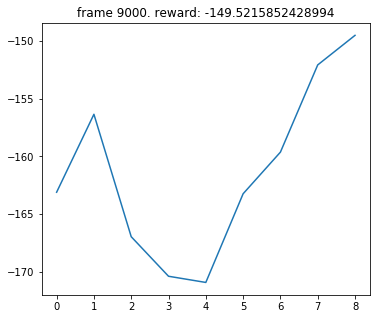

In [ ]:
i_update = 0
state = envs.reset()
early_stop = False
done = False

while frame_idx < max_frames and not early_stop:
    i_update += 1
    
    log_probs = []
    values    = []
    states    = []
    actions   = []
    rewards   = []
    masks     = []
    entropy = 0

    for _ in range(num_steps):
        state = torch.FloatTensor(state).to(device)
        dist, value = model(state)

        action = dist.sample()
        next_state, reward, done, _ = envs.step(action.cpu().numpy())
        reward = expert_reward(state, action.cpu().numpy())
        
        log_prob = dist.log_prob(action)
        entropy += dist.entropy().mean()
        
        log_probs.append(log_prob)
        values.append(value)
        rewards.append(torch.FloatTensor(reward).to(device))
        masks.append(torch.FloatTensor(1 - done).unsqueeze(1).to(device))
        
        states.append(state)
        actions.append(action)
        
        state = next_state
        frame_idx += 1
        # if done
        
        if frame_idx % 1000 == 0:
            test_reward = np.mean([test_env() for _ in range(10)])
            test_rewards.append(test_reward)
            plot(frame_idx, test_rewards)
            if test_reward > threshold_reward:early_stop = True
            

    next_state = torch.FloatTensor(next_state).to(device)
    _, next_value = model(next_state)
    returns = compute_gae(next_value, rewards, masks, values)

    returns   = torch.cat(returns).detach()
    log_probs = torch.cat(log_probs).detach()
    values    = torch.cat(values).detach()
    states    = torch.cat(states)
    actions   = torch.cat(actions)
    advantage = returns - values
    
    if i_update % 3 == 0:
        ppo_update(4, mini_batch_size, states, actions, log_probs, returns, advantage)
    
    
    expert_state_action = expert_traj[np.random.randint(0, expert_traj.shape[0], 2 * num_steps * num_envs), :]
    expert_state_action = torch.FloatTensor(expert_state_action).to(device)
    state_action        = torch.cat([states, actions], 1)
    fake = discriminator(state_action)
    real = discriminator(expert_state_action)
    optimizer_discrim.zero_grad()
    discrim_loss = discrim_criterion(fake, torch.ones((states.shape[0], 1)).to(device)) + \
            discrim_criterion(real, torch.zeros((expert_state_action.size(0), 1)).to(device))
    discrim_loss.backward()
    optimizer_discrim.step()

ここまで本番

In [ ]:
#動作テスト
import time
from itertools import count

max_expert_num = 50000
num_steps = 0
expert_traj = []

for i_episode in count():
    state = env.reset()
    done = False
    total_reward = 0
    for step in range(num_steps):
        action = policy_net.get_action(state)
        next_state, reward, done, _ = env.step(action)
        state = next_state
        total_reward += reward
        num_steps += 1
        expert_traj.append(np.hstack([state, action]))
        env.render()
        time.sleep(0.01)
        print(step)
        if done:
            break
    #print("episode:", i_episode, "reward:", total_reward)        
    if num_steps >= max_expert_num:
        break
        
expert_traj = np.stack(expert_traj)
print()
print(expert_traj.shape)
print()
#np.save("expert_traj.npy", expert_traj)

In [ ]:
#test_env_multi(dist,True,10)
for i_episode in range(10):
    state = env.reset()
    total_reward = 0
    for step in range(num_steps):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        dist,_ = model(state)
        next_state, reward, done, _ = env.step(dist.sample().cpu().numpy()[0])
        state = next_state
        total_reward += reward
        env.render()
        time.sleep(0.05)
    if done:break
    print("episode:", i_episode, "reward:", total_reward)    


In [ ]:
test_env(True)